# Zarr output exploitation

This notebook consumes the STAC Collection that describes the detected water bodies zarr.

In [1]:
import pystac
import os
from pystac.extensions.datacube import DatacubeExtension
import xarray as xr
import nest_asyncio
import yaml
import json
import rioxarray 
import pandas as pd
nest_asyncio.apply()

## Dependencies

The notebook execution depends on the outputs of notebook **2-CWL-Workflows/1-Zarr-Cloud-native-format** which produces the STAC Collection and Zarr.


In [2]:
os.chdir("/workspace/zarr-cloud-native-format/runs")

# check if file zarr-cloud-native-example.zarr exists
if not os.path.exists("zarr-cloud-native-results.json"):
    print("File zarr-cloud-native-example.zarr does not exist. Please run the previous notebooks first.")

## Discover the STAC results 

The execution of the application package "app-water-bodies.0.3.0.cwl" produces the file "zarr-cloud-native-results.json":


In [3]:
with open("zarr-cloud-native-results.json", "r") as f:
    results = json.load(f)

list(results.keys())

['zarr_stac_catalog', 'stac_catalog']

We're interested in the `zarr_stac_catalog` output, a directory that includes a STAC Catalog:

In [4]:
results["zarr_stac_catalog"]["path"]

'/workspace/zarr-cloud-native-format/runs/gaaevbi7'

Open the STAC Catalog with `pystac`:

In [5]:
cat = pystac.Catalog.from_file(
    os.path.join(
        results["zarr_stac_catalog"]["path"], "catalog.json"
    )
)

The STAC Catalog contains a STAC Collection with the id _water-bodies_:

In [6]:
cat.describe()

* <Catalog id=water-bodies>
    * <Collection id=water-bodies>


In [7]:
collection = cat.get_child("water-bodies")

## STAC Datacube extension content

Use the Datacube STAC extension:

In [8]:
dc_collection = DatacubeExtension.ext(collection)

Print the datacube dimensions:

In [9]:
for key, dim in dc_collection.dimensions.items():
    print(f"Dimension: {key}, Type: {dim.dim_type}, Extent: {dim.extent}")

    


Dimension: x, Type: spatial, Extent: [636995.0, 691585.0]
Dimension: y, Type: spatial, Extent: [4410555.0, 4482595.0]
Dimension: time, Type: temporal, Extent: ['2021-06-28T19:03:24.330000000', '2021-07-28T19:03:25.963000000']


Print the datacube variable(s):

In [10]:
for key, variable in dc_collection.variables.items():
    print(f"Variable: {key}, Description: {variable.description}, Dimensions: {','.join(variable.dimensions)}, Type: {variable.var_type}")

Variable: data, Description: detected water bodies, Dimensions: y,x,time, Type: bands


In [11]:
dc_collection.variables["data"].to_dict()

{'type': 'bands',
 'name': 'data',
 'description': 'detected water bodies',
 'dimensions': ['y', 'x', 'time'],
 'chunks': [512, 512, 1]}

## Zarr STAC Asset

In [12]:
zarr_asset = collection.get_assets()["data"]

print(f"Asset Title: {zarr_asset.title}, Asset Href: {zarr_asset.href}")

Asset Title: Detected water bodies, Asset Href: result.zarr


In [13]:
zarr_asset.extra_fields

{'xarray:open_kwargs': {'consolidated': True}}

Open the Zarr:

In [14]:
water_bodies = xr.open_zarr(zarr_asset.get_absolute_href(), **zarr_asset.extra_fields["xarray:open_kwargs"])


In [15]:
xr.set_options(display_style="text")

water_bodies

<xarray.Dataset> Size: 315MB
Dimensions:      (time: 8, y: 7205, x: 5460)
Coordinates:
  * time         (time) datetime64[ns] 64B 2021-06-28T19:03:24.330000 ... 202...
  * x            (x) float64 44kB 6.37e+05 6.37e+05 ... 6.916e+05 6.916e+05
  * y            (y) float64 58kB 4.483e+06 4.483e+06 ... 4.411e+06 4.411e+06
Data variables:
    data         (time, y, x) uint8 315MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    spatial_ref  int32 4B ...

In [16]:
water_bodies.data_vars["spatial_ref"]

<xarray.DataArray 'spatial_ref' ()> Size: 4B
[1 values with dtype=int32]
Attributes: (12/18)
    GeoTransform:                      636990 10 0 4482600 0 -10
    crs_wkt:                           PROJCRS["WGS 84 / UTM zone 10N",BASEGE...
    false_easting:                     500000.0
    false_northing:                    0.0
    geographic_crs_name:               WGS 84
    grid_mapping_name:                 transverse_mercator
    ...                                ...
    projected_crs_name:                WGS 84 / UTM zone 10N
    reference_ellipsoid_name:          WGS 84
    scale_factor_at_central_meridian:  0.9996
    semi_major_axis:                   6378137.0
    semi_minor_axis:                   6356752.314245179
    spatial_ref:                       PROJCRS["WGS 84 / UTM zone 10N",BASEGE...

In [17]:
str(water_bodies.data_vars["spatial_ref"].values)

'32610'

Read the xarray coordinates:

In [18]:
for coord in water_bodies.coords:
    print(f"Coordinate: {coord}, Type: {water_bodies.coords[coord].dtype}, Shape: {water_bodies.coords[coord].shape}")


Coordinate: time, Type: datetime64[ns], Shape: (8,)
Coordinate: x, Type: float64, Shape: (5460,)
Coordinate: y, Type: float64, Shape: (7205,)


Read the `time` coordinate values:

In [19]:
[pd.to_datetime(t).to_pydatetime().isoformat() for t in list(water_bodies.coords["time"].values)]

['2021-06-28T19:03:24.330000',
 '2021-07-08T19:03:25.409000',
 '2021-07-08T19:03:25.410000',
 '2021-07-13T19:03:24.627000',
 '2021-07-18T19:03:25.940000',
 '2021-07-23T19:03:24.661000',
 '2021-07-28T19:03:25.962000',
 '2021-07-28T19:03:25.963000']

Print one observation:

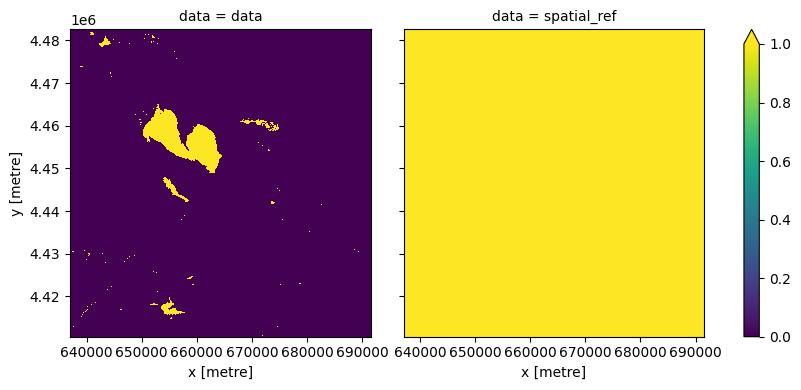

In [20]:
_ = (
    water_bodies.isel(time=3)
    .to_array("data")
    .plot.imshow(
        col="data",
        size=4,
        vmin=0,
        vmax=1,
    )
)

Calculate the mean:

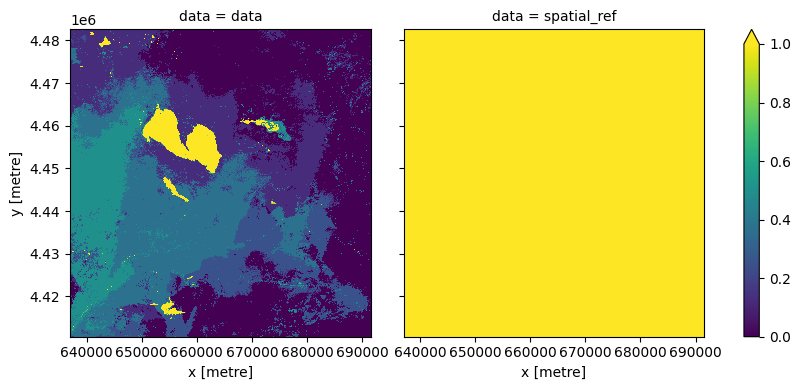

In [21]:
water_bodies.mean(dim="time").to_array("data").plot.imshow(col="data", size=4, vmin=0, vmax=1)

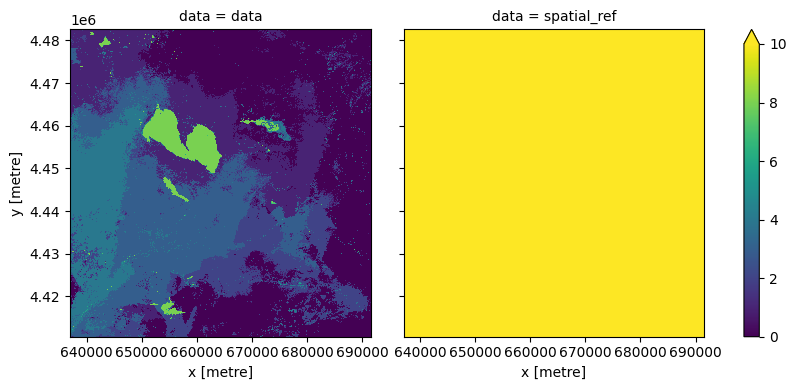

In [22]:
water_bodies.sum(dim="time").to_array("data").plot.imshow(col="data", size=4, vmin=0, vmax=10)

Save the mean to a geotiff file:

In [23]:


agg = water_bodies.mean(dim="time").to_array("data") 

agg = agg.rio.write_crs(f"EPSG:{str(water_bodies.data_vars['spatial_ref'].values)}")

# Write to GeoTIFF
agg.rio.to_raster("water_bodies_mean.tif")